# Compare RNA-seq counts of intergenic intervals that overlap with an ATAC-seq peak vs. those that don't

In [1]:
import pandas as pd
from collections import defaultdict

### Load peaks data

In [2]:
raw_peaks_df = pd.read_csv('ENCSR885DVH/ENCFF879FSD.bed', sep='\t', header=None)


# For some reason (which I need to look into), there are multiple peaks
# with the same start and end coordinates. I need to collapse these entries
# down into a single interval.
interval_to_ids = defaultdict(lambda: [])
for r_i, row in raw_peaks_df.iterrows():
    chrm = row[0]
    begin = row[1]
    end = row[2]
    peak_id = row[3]
    interval_to_ids[(chrm, begin, end)].append(peak_id)
da = [
    (k[0], k[1], k[2], ','.join(v))
    for k, v in interval_to_ids.items()
]
peaks_df = pd.DataFrame(
    data=da,
    columns=[
        'chromsome', 
        'begin', 
        'end', 
        'peak_ids'
    ]
)
peaks_df

,chromsome,begin,end,peak_ids
0,chr1,100027916,100029543,"Peak_162534,Peak_189829,Peak_205380,Peak_23225..."
1,chr1,100036789,100037403,"Peak_133803,Peak_173137,Peak_67659"
2,chr1,100037554,100039283,"Peak_144687,Peak_179877,Peak_39266,Peak_44011,..."
3,chr1,100048434,100048996,"Peak_189438,Peak_222062"
4,chr1,100049436,100049815,"Peak_175134,Peak_199830"
...,...,...,...,...
135845,chrX,9995829,9996095,Peak_69685
135846,chrY,11097622,11097859,Peak_207213
135847,chrY,11098228,11099027,"Peak_119573,Peak_267499"
135848,chrY,12394970,12395294,"Peak_227283,Peak_267500"


### Load intergenic RNA-seq interval counts data

In [3]:
rnaseq_df = pd.read_csv('output/ENCSR885DVH_ENCFF625ZBS.interval_counts.200_bp.ORIG.tsv', sep='\t')
rnaseq_df 

,interval_id,chromosome,interval_begin,interval_end,n_reads
0,chr1.1000_1200,chr1,1000,1200,0
1,chr1.1200_1400,chr1,1200,1400,0
2,chr1.1400_1600,chr1,1400,1600,0
3,chr1.1600_1800,chr1,1600,1800,0
4,chr1.1800_2000,chr1,1800,2000,0
...,...,...,...,...,...
7193533,chrY.57182169_57182369,chrY,57182169,57182369,0
7193534,chrY.57182369_57182569,chrY,57182369,57182569,0
7193535,chrY.57182569_57182769,chrY,57182569,57182769,0
7193536,chrY.57182769_57182969,chrY,57182769,57182969,0


### Compute which intervals overlap with an ATAC-seq peak

In [20]:
chrm_to_peaks = {
    chrm: peaks_df.loc[peaks_df['chromsome'] == chrm]
    for chrm in set(peaks_df['chromsome'])
}
chrm_to_peaks = {
    chrm: peaks_df.sort_values(by='begin')
    for chrm, peaks_df in chrm_to_peaks.items()
}
chrm_to_peak_begins = {
    chrm: list(df['begin'])
    for chrm, df in chrm_to_peaks.items()
}
chrm_to_peak_ends = {
    chrm: list(df['end'])
    for chrm, df in chrm_to_peaks.items()
}

# Set to True to output messages
debug = False

ints_in_peaks = []
ints_outside_peaks = []
for chrm, peak_begins in chrm_to_peak_begins.items():
    print("Processing chromosome {}".format(chrm))
    peak_ends = chrm_to_peak_ends[chrm]
    chrm_rnaseq_df = rnaseq_df.loc[rnaseq_df['chromosome'] == chrm]
    chrm_rnaseq_df = chrm_rnaseq_df.sort_values(by='interval_begin')
    interval_begins = list(chrm_rnaseq_df['interval_begin'])
    interval_ends = list(chrm_rnaseq_df['interval_end'])
    peak_i = 0
        
    for int_i, (_, row) in enumerate(chrm_rnaseq_df.iterrows()):
        interval_id = row['interval_id']
        int_begin = interval_begins[int_i]
        int_end = interval_ends[int_i]
        
        if int_begin >= peak_begins[peak_i]:
            # The interval beginning has crossed over 
            # a peak's beginning
            if int_begin > peak_ends[peak_i]:
                #   The interval is now passed the peak:
                # 
                #   interval: ---------[------]--
                #   peak:     --[---]------------
                if debug:
                    print('Interval ({}, {}) has now passed current peak ({}, {})'.format(
                        int_begin,
                        int_end,
                        peak_begins[peak_i],
                        peak_ends[peak_i]
                    ))
                if peak_i < len(peak_begins)-1:
                    peak_i += 1
                if debug:
                    print('New peak: ({}, {})'.format(
                        peak_begins[peak_i],
                        peak_ends[peak_i]
                    ))
                ints_outside_peaks.append(interval_id)
            elif int_begin <= peak_ends[peak_i]:
                #   The beginning of interval is within
                #   the peak:
                #
                #   interval: ------[-----]----
                #   peak:     ---[-----]------
                #
                #   interval: ------[-----]----
                #   peak:     ---[----------]--
                if debug:
                    print('Interval ({}, {}) overlaps current peak ({}, {})'.format(
                        int_begin,
                        int_end,
                        peak_begins[peak_i],
                        peak_ends[peak_i]
                    ))
                peak_id = chrm_to_peaks[chrm].iloc[peak_i]['peak_ids']
                ints_in_peaks.append((interval_id, peak_id))
        elif int_begin < peak_begins[peak_i]:
            if int_end >= peak_begins[peak_i]:
                #   The interval overlaps the beginning 
                #   of the peak:
                #
                #   interval: -[-----]--------
                #   peak:     ---[-----]------
                #
                #   interval: -[-------------]-
                #   peak:     ---[---------]---
                # 
                if debug:
                    print('Interval ({}, {}) overlaps current peak ({}, {})'.format(
                        int_begin,
                        int_end,
                        peak_begins[peak_i],
                        peak_ends[peak_i]
                    ))
                peak_id = chrm_to_peaks[chrm].iloc[peak_i]['peak_ids']
                ints_in_peaks.append((interval_id, peak_id))
            elif int_end < peak_begins[peak_i]:
                #   The interval preceeds the peak:
                #
                #   interval: --[---]-----------
                #   peak:     ----------[----]--
                ints_outside_peaks.append(interval_id)
 
print('{} intervals in a peak'.format(len(ints_in_peaks)))
print('{} intervals outside a peak'.format(len(ints_outside_peaks)))
    

Processing chromosome chrX
Processing chromosome chr20
Processing chromosome chr12
Processing chromosome chr16
Processing chromosome chr6
Processing chromosome chr8
Processing chromosome chr19
Processing chromosome chr10
Processing chromosome chr18
Processing chromosome chr11
Processing chromosome chr7
Processing chromosome chr13
Processing chromosome chr15
Processing chromosome chr2
Processing chromosome chrY
Processing chromosome chr3
Processing chromosome chr9
Processing chromosome chr14
Processing chromosome chr22
Processing chromosome chr17
Processing chromosome chr4
Processing chromosome chr21
Processing chromosome chr1
Processing chromosome chr5
159890 intervals in a peak
7033648 intervals outside a peak


In [21]:
ints_in_peaks[:10]

[('chrX.12600_12800', 'Peak_220375,Peak_270645'),
 ('chrX.12800_13000', 'Peak_220375,Peak_270645'),
 ('chrX.13000_13200', 'Peak_220375,Peak_270645'),
 ('chrX.14000_14200', 'Peak_36870'),
 ('chrX.14200_14400', 'Peak_36870'),
 ('chrX.14400_14600', 'Peak_36870'),
 ('chrX.18800_19000',
  'Peak_107552,Peak_249828,Peak_6451,Peak_64840,Peak_94523'),
 ('chrX.19000_19200',
  'Peak_107552,Peak_249828,Peak_6451,Peak_64840,Peak_94523'),
 ('chrX.19200_19400',
  'Peak_107552,Peak_249828,Peak_6451,Peak_64840,Peak_94523'),
 ('chrX.19400_19600',
  'Peak_107552,Peak_249828,Peak_6451,Peak_64840,Peak_94523')]

In [22]:
in_peak_counts = rnaseq_df.set_index('interval_id').loc[[x[0] for x in ints_in_peaks]]['n_reads']
out_peak_counts = rnaseq_df.set_index('interval_id').loc[ints_outside_peaks]['n_reads']
da = [
    (x, 'Within Peak')
    for x in in_peak_counts
]
da += [
    (x, 'Outside Peak')
    for x in out_peak_counts
]
df_in_out_peak_count = pd.DataFrame(
    data=da,
    columns=['Count', 'Peak-Status']
)
df_in_out_peak_count

,Count,Peak-Status
0,0,Within Peak
1,0,Within Peak
2,0,Within Peak
3,0,Within Peak
4,0,Within Peak
...,...,...
7193533,32,Outside Peak
7193534,43,Outside Peak
7193535,40,Outside Peak
7193536,20,Outside Peak


### Look at the distribution of counts for intervals within a peak vs. outside a peak

(0.0, 20.0)

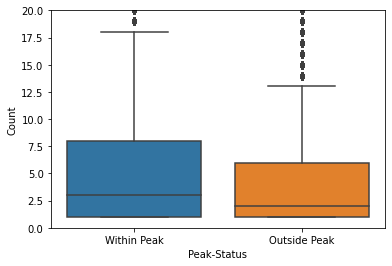

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns

df_in_out_peak_count = df_in_out_peak_count.loc[df_in_out_peak_count['Count']>0]

sns.boxplot(data=df_in_out_peak_count, x='Peak-Status', y='Count')
plt.ylim((0,20))

### Look at fraction of intervals with zero counts within a peak vs. outside a peak

In [40]:
frac_zero_in_peak = len([x for x in in_peak_counts if x == 0])/len(in_peak_counts)
frac_zero_out_peak = len([x for x in out_peak_counts if x == 0])/len(out_peak_counts)
print("Fraction of zero counts within peak: ", frac_zero_in_peak)
print("Fraction of zero counts outside peak: ", frac_zero_out_peak)

Fraction of zero counts within peak:  0.7699418350115704
Fraction of zero counts outside peak:  0.9100182437335504


### Perform a Wilcoxon Rank-Sum test to see if distribution of counts are different between the two

In [42]:
from scipy.stats import ranksums

_, p_val = ranksums(in_peak_counts, out_peak_counts)
print('p-value: ', p_val)

p-value:  0.0
